# W2V MLP

### Imports

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import optuna
import random

# import modules
from model.mlp import (
    LanguageModelNN,
    LanguageModelNN_Dropout,
    TextDataset,
    train_mlp,
    validate_mlp,
    save_mlp,
    load_mlp,
)

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from spacy.lang.de.stop_words import STOP_WORDS

import mlflow
import mlflow.pytorch

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# If using CUDA
torch.cuda.manual_seed_all(seed)

# Define experiment
mlflow.set_experiment("W2V")
mlflow.pytorch.autolog()


%load_ext autoreload
%autoreload 2

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading data into a Dataframe (df)

In [3]:
df = pd.read_parquet("../data/de_poems.parquet")
df = df.astype(
    {"title": "string", "text": "string", "author": "string", "creation": "int64"}
)
df.dtypes


title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

In [4]:
# Convertir les dates en siècles, en gérant les valeurs None
# D'abord, créer une copie pour ne pas modifier l'original
df_siecles = df.copy()

# Convertir uniquement les valeurs non-nulles en entiers puis en siècles
# Assurons-nous que toutes les valeurs sont soit des nombres, soit des NaN
df_siecles["creation"] = pd.to_numeric(df_siecles["creation"], errors="coerce")

# Maintenant, appliquer la conversion en siècles seulement sur les valeurs non-nulles
mask = df_siecles["creation"].notna()
df_siecles.loc[mask, "creation"] = df_siecles.loc[mask, "creation"].apply(
    lambda x: (x - 1) // 100 + 1
)

# Remplacer df par df_siecles pour conserver les modifications
df = df_siecles

In [5]:
# Filtrer les lignes où creation est None
df_none_creation = df[df["creation"].isnull()]


# Grouper par author pour voir combien de poèmes chaque author a avec creation = None
authors_avec_none = (
    df_none_creation.groupby("author").size().sort_values(ascending=False)
)

# Pour chaque author ayant des poèmes sans date, vérifier s'il a aussi des poèmes avec date
authors_a_corriger = []
for author in df_none_creation["author"].unique():
    dates_disponibles = df[df["author"] == author]["creation"].dropna().unique()
    if len(dates_disponibles) > 0:
        authors_a_corriger.append((author, dates_disponibles))


# Fonction pour remplir les dates manquantes avec la médiane des dates de l'author
def remplir_dates_manquantes(df):
    df_copy = df.copy()

    for author in df[df["creation"].isna()]["author"].unique():
        dates = df[df["author"] == author]["creation"].dropna()
        if len(dates) > 0:
            # Utiliser la médiane des dates disponibles pour cet author
            date_mediane = int(np.median(dates))
            # Remplir les valeurs manquantes pour cet author
            mask = (df_copy["author"] == author) & (df_copy["creation"].isna())
            df_copy.loc[mask, "creation"] = date_mediane

    return df_copy


# Appliquer la fonction pour remplir les dates manquantes
df_corrige = remplir_dates_manquantes(df)

# Vérifier combien de dates ont été corrigées
nb_corriges = len(df) - df_corrige["creation"].isna().sum()
nb_restants = df_corrige["creation"].isna().sum()

print(f"\nNombre de dates corrigées: {nb_corriges - (len(df) - len(df_none_creation))}")
print(f"Nombre de poèmes restants sans date: {nb_restants}")

df = df_corrige.dropna()


Nombre de dates corrigées: 0
Nombre de poèmes restants sans date: 0


### Tokenizing text

#### NLTK

In [9]:
nltk.download("punkt_tab")

def preprocess_text_wordTokenize(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^\w\s]+", "", text)
    tokens = word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/erwinrodrigues/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

def preprocess_text_lemmatize(text):
    text = re.sub(r"[^\w\s'-]+", "", text)
    tokens = word_tokenize(re.sub(r"[^\w\s]+", "", text.lower()))
    return [lemmatizer.lemmatize(token) for token in tokens]


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erwinrodrigues/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def preprocess_text_stemmer(text):
    text = re.sub(r"[^\w\s'-]+", "", text)
    tokens = word_tokenize(re.sub(r"[^\w\s]+", "", text.lower()))
    stemmer = SnowballStemmer("german")
    return [stemmer.stem(token) for token in tokens]

In [12]:
df["tokens"] = df["text"].apply(preprocess_text_stemmer)

#### Spacy

In [14]:
nlp = spacy.load("de_core_news_sm")
# python -m spacy download de_core_news_sm


def preprocess_text_spacy(doc):
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens


def preprocess_text_spacy_stopwords(doc):
    filtered_tokens = [
        token.lemma_
        for token in doc
        if not token.is_punct and token.lemma_.lower() not in STOP_WORDS
    ]
    return filtered_tokens


In [33]:
texts = df["text"].tolist()
docs = list(nlp.pipe(texts, batch_size=1000, n_process=4))

df["tokens"] = [preprocess_text_spacy_stopwords(doc) for doc in docs]

In [34]:
df.to_csv("spacy_tokenized.csv")

In [6]:
df = pd.read_csv("spacy_tokenized.csv")

### Training Word 2 Vec on the tokenized texts

In [ ]:
tokenized_poems = df["tokens"].tolist()
model_df = Word2Vec(tokenized_poems, vector_size=100, window=5, min_count=2, workers=4)

model_df.save("word2vec_df.model")

#### W2V Boosted

In [35]:
model_df = Word2Vec(
    sentences=df["tokens"],
    vector_size=500,
    window=20,
    min_count=2,
    workers=32,
    epochs=50,
    seed=42,
)

model_df.save("word2vec_boosted2.model")

In [7]:
model_df = Word2Vec.load("word2vec_boosted2.model")

### Embedding Text && Encoding Century

In [8]:
def text_to_embedding(tokens, model, embedding_dim=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

def vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size * 2)
    vectors = np.array(vectors)
    mean_vec = vectors.mean(axis=0)
    max_vec = vectors.max(axis=0)
    return np.concatenate([mean_vec, max_vec])


df["embedding"] = df["tokens"].apply(lambda x: text_to_embedding(x, model_df))
#df["embedding"] = df["tokens"].apply(lambda x: vectorize(x, model_df))

In [9]:
from sklearn.preprocessing import StandardScaler

label_encoder = LabelEncoder()
df.loc[:, "creation"] = label_encoder.fit_transform(df["creation"])

x = torch.tensor(np.stack(df["embedding"].values), dtype=torch.float32)
y = torch.tensor(df["creation"].values, dtype=torch.long)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

## MLP

### Creating the data loaders

In [10]:
train_dataset = TextDataset(x_train, y_train)
val_dataset = TextDataset(x_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Creating model and hyperparameters

In [11]:
embedding_dim = 500
hidden_size = 128
num_classes = len(df["century_label"].unique())

class_counts = np.bincount(df["century_label"])
class_weights = 1.0 / class_counts

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = LanguageModelNN(embedding_dim, hidden_size, num_classes)
# model = LanguageModelNN_Dropout(num_classes)
model.apply(initialize_weights)

loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


### Training and Validating model

In [12]:
mlflow.end_run()    
mlp_training_time = train_mlp(model, train_loader, loss_fn, optimizer, num_epochs=200)

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/multi_layer_perceptron/model/mlp.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(


Epoch 1/200, Loss: 1.2125
Epoch 2/200, Loss: 1.1517
Epoch 3/200, Loss: 1.1259
Epoch 4/200, Loss: 1.1052
Epoch 5/200, Loss: 1.0988
Epoch 6/200, Loss: 1.0820
Epoch 7/200, Loss: 1.0756
Epoch 8/200, Loss: 1.0682
Epoch 9/200, Loss: 1.0593
Epoch 10/200, Loss: 1.0576
Epoch 11/200, Loss: 1.0524
Epoch 12/200, Loss: 1.0494
Epoch 13/200, Loss: 1.0437
Epoch 14/200, Loss: 1.0435
Epoch 15/200, Loss: 1.0389
Epoch 16/200, Loss: 1.0378
Epoch 17/200, Loss: 1.0312
Epoch 18/200, Loss: 1.0360
Epoch 19/200, Loss: 1.0308
Epoch 20/200, Loss: 1.0271
Epoch 21/200, Loss: 1.0266
Epoch 22/200, Loss: 1.0216
Epoch 23/200, Loss: 1.0247
Epoch 24/200, Loss: 1.0220
Epoch 25/200, Loss: 1.0192
Epoch 26/200, Loss: 1.0177
Epoch 27/200, Loss: 1.0151
Epoch 28/200, Loss: 1.0149
Epoch 29/200, Loss: 1.0131
Epoch 30/200, Loss: 1.0101
Epoch 31/200, Loss: 1.0094
Epoch 32/200, Loss: 1.0060
Epoch 33/200, Loss: 1.0080
Epoch 34/200, Loss: 1.0066
Epoch 35/200, Loss: 1.0065
Epoch 36/200, Loss: 1.0044
Epoch 37/200, Loss: 1.0021
Epoch 38/2

In [26]:
save_mlp(model, label_encoder, val_loader, mlp_training_time)

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/multi_layer_perceptron/model/mlp.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(


MLP model saved successfully to model/saved/mlp_model.pt


In [27]:
model, label_encoder, val_loader, config, mlp_training_time = load_mlp()

## Evaluation

### Evaluation for MLP Model


=== Validation Metrics ===
Accuracy: 0.6302
Precision: 0.6025
Recall: 0.6302
F1-Score: 0.6070
Specificity: 0.9359
AUC (micro): 0.9391
Validation time: 0.21s


/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


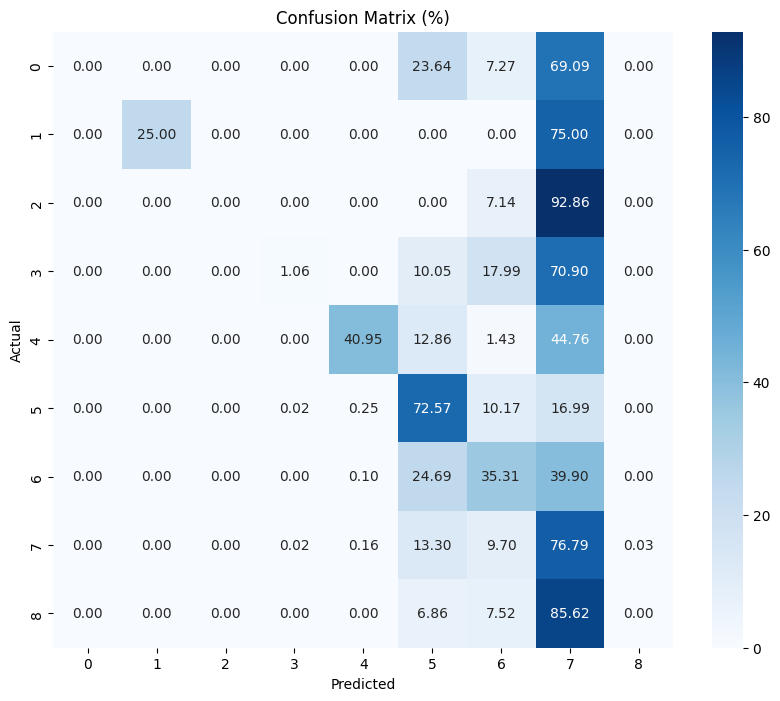

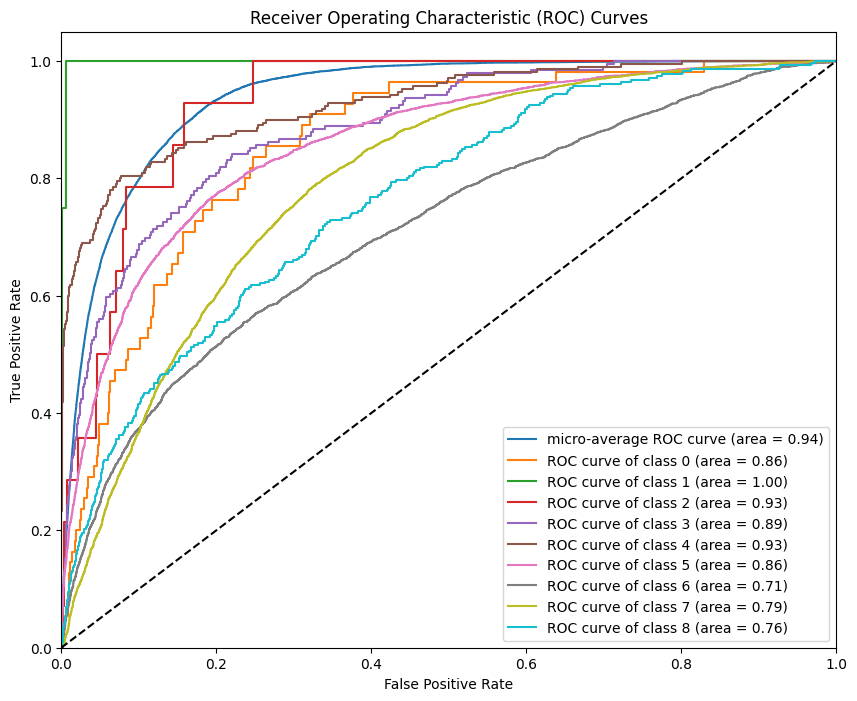


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       1.00      0.25      0.40         4
           2       0.00      0.00      0.00        14
           3       0.50      0.01      0.02       189
           4       0.79      0.41      0.54       210
           5       0.63      0.73      0.68      4032
           6       0.50      0.35      0.41      3115
           7       0.66      0.77      0.71      6389
           8       0.00      0.00      0.00       306

    accuracy                           0.63     14314
   macro avg       0.45      0.28      0.31     14314
weighted avg       0.60      0.63      0.61     14314



/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [13]:
validate_mlp(model, val_loader, label_encoder)

## HyperParam Optimization

In [ ]:
def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_choice = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])

    # Model creation with dropout
    model = LanguageModelNN_Dropout(num_classes=num_classes, dropout=dropout_rate)
    model = model.to(device)  # Move model to GPU

    # Dataset & DataLoader
    train_dataset = TextDataset(x_train, y_train)
    val_dataset = TextDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    loss_fn = nn.CrossEntropyLoss(reduction="mean")

    # Optimizer selection
    if optimizer_choice == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_choice == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Early stopping parameters
    patience = 100
    best_val_acc = 0
    patience_counter = 0

    # Training
    for epoch in range(50):
        model.train()
        train_losses = []

        for batch_X, batch_y in train_loader:
            # Move tensors to the right device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = sum(train_losses) / len(train_losses)

        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        val_losses = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = loss_fn(outputs, batch_y)
                val_losses.append(loss.item())

                preds = torch.argmax(outputs, dim=1)

                # Move back to CPU for numpy conversion
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

        # Calculate metrics
        current_val_acc = accuracy_score(all_labels, all_preds)
        avg_val_loss = sum(val_losses) / len(val_losses)

        # Log metrics (optional)
        print(
            f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {current_val_acc:.4f}"
        )

        # Report to Optuna for pruning
        trial.report(current_val_acc, epoch)

        # Handle pruning - stop this trial if it's not promising
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping logic
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            patience_counter = 0
            # Save best model (optional)
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Load best model weights before final evaluation (optional)
    if "best_model_state" in locals():
        model.load_state_dict(best_model_state)

    # Final evaluation on validation set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_acc = accuracy_score(all_labels, all_preds)

    return final_acc  # Return the best validation accuracy


def run_optuna_optimization(n_trials=20):
    # Create pruner
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,  # Number of trials to run before pruning
        n_warmup_steps=5,  # Number of epochs in each trial before pruning
        interval_steps=1,  # Report and check for pruning after each epoch
    )

    # Create study with the pruner
    study = optuna.create_study(
        direction="maximize", pruner=pruner, study_name="nlp_model_optimization"
    )

    # Run optimization
    study.optimize(objective, n_trials=n_trials)

    # Print results
    print("\nStudy statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(
        f"  Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}"
    )
    print(
        f"  Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}"
    )

    print("\nBest trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study


In [ ]:
study = run_optuna_optimization(n_trials=100)

In [ ]:
values = [trial.value for trial in study.trials]

plt.figure(figsize=(10, 6))
plt.plot(values, label="Objective Value")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.title("Optimization History")
plt.legend()
plt.show()

In [ ]:
importances = optuna.importance.get_param_importances(study)
param_names = list(importances.keys())
importances_df = pd.DataFrame(
    list(importances.items()), columns=["Hyperparameter", "Importance"]
)


plt.figure(figsize=(10, 6))
importances_df.plot(kind="bar", x="Hyperparameter", y="Importance", legend=False)
plt.xlabel("Hyperparameters")
plt.ylabel("Importance")
plt.title("Parameter Importances")
plt.show()

In [ ]:
best_params = study.best_params

final_model = LanguageModelNN_Dropout(
    num_classes=num_classes, dropout=best_params["dropout"]
)
final_model = final_model.to(device)

# Setup with best hyperparameters
if best_params["optimizer"] == "Adam":
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_params["lr"])
else:
    final_optimizer = optim.AdamW(final_model.parameters(), lr=best_params["lr"])

## Pipeline

In [104]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming df['embedding'] is a column of w2v vectors
X = np.vstack(df["embedding"].values)
y = df["century_label"].values

# Split FIRST to avoid data leak
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)



In [105]:
# Define the pipeline
pipe = Pipeline(
    [
        ("smote", SMOTE()),
        ("scale", StandardScaler()),
        ("pca", PCA()),
        (
            "mlp",
            MLPClassifier(
                early_stopping=True, n_iter_no_change=10, max_iter=300, random_state=42
            ),
        ),
    ]
)

# Define hyperparameter grid
param_grid = {
    "pca__n_components": [30, 50, 70],
    "mlp__hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "mlp__alpha": [0.0001, 0.0005, 0.001],
    "mlp__solver": ["adam", "lbfgs"],
    "mlp__activation": ["relu", "tanh"],
}


In [106]:
# Use Stratified CV to tune
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

/Users/erwinrodrigues/school/nlp/project/NLP1-Poetry/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

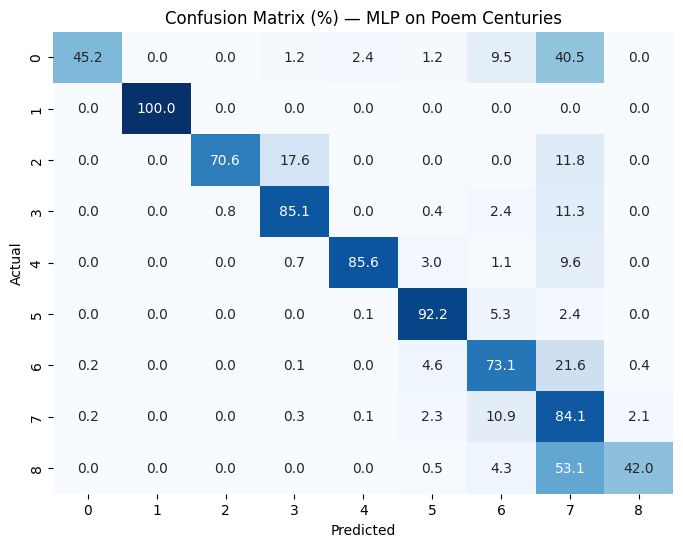

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# After training
y_pred = pipe.predict(X_test)

# Raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize rows to get % per actual class
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Pretty plot with Seaborn
centuries = sorted(np.unique(y))  # or custom: ['15th', '16th', ...]
df_cm = pd.DataFrame(cm_percent, index=centuries, columns=centuries)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt=".1f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (%) — MLP on Poem Centuries")
plt.show()

## Geneartion

In [17]:
def generate_poem_for_century(
    century, model, word2vec_model, max_length=50, temperature=0.7
):
    """
    Generate a poem for a specific century using the trained model.

    Args:
        century (int): The target century
        model: The trained MLP model
        word2vec_model: The trained Word2Vec model
        max_length (int): Maximum length of the generated poem
        temperature (float): Controls randomness (higher = more random)
    """
    # Get all words from the vocabulary
    vocabulary = list(word2vec_model.wv.key_to_index.keys())

    # Start with a random word
    current_word = np.random.choice(vocabulary)
    generated_poem = [current_word]

    for _ in range(max_length):
        # Get the word vector for the current word
        if current_word in word2vec_model.wv:
            word_vector = word2vec_model.wv[current_word]

            # Reshape for model input
            input_vector = torch.tensor(word_vector, dtype=torch.float32).unsqueeze(0)

            # Get model prediction
            with torch.no_grad():
                output = model(input_vector)

            # Apply temperature
            output = output / temperature

            # Convert to probabilities
            probs = torch.softmax(output, dim=1)

            # Sample next word based on probabilities
            next_word_idx = torch.multinomial(probs, 1).item()
            next_word = vocabulary[next_word_idx]

            generated_poem.append(next_word)
            current_word = next_word

            # Add some randomness to break repetitive patterns
            if np.random.random() < 0.1:
                current_word = np.random.choice(vocabulary)

    return " ".join(generated_poem)


def format_poem(text, line_length=40):
    """
    Format the generated text into poem-like lines
    """
    words = text.split()
    lines = []
    current_line = []
    current_length = 0

    for word in words:
        if current_length + len(word) + 1 <= line_length:
            current_line.append(word)
            current_length += len(word) + 1
        else:
            lines.append(" ".join(current_line))
            current_line = [word]
            current_length = len(word)

    if current_line:
        lines.append(" ".join(current_line))

    return "\n".join(lines)


In [42]:
# Generate a poem for the 19th century
century = 19
generated_poem = generate_poem_for_century(
    century, model, model_df, max_length=1000
)
formatted_poem = format_poem(generated_poem, line_length=40)
print(f"Generated Poem for the {century}th Century:")
print(formatted_poem)

Generated Poem for the 19th Century:
bespringt nicht in in in in in in in in
in in in in in in in in in nicht in in
in in in in in in in nicht in in in in
in nicht in in den nicht in in in in in
in in in in in in in in in in in in in
in in in in in nicht in in in in in in
in in in in in in in in den nicht in in
in in in in in in in in in in in in in
in in in in in in den nicht in in in in
in in in in in in in in in in in in in
in in in in in in in in in nicht in in
in in den nicht in in in in in in in den
nicht in in in in in in in in in in in
in in in in nicht in in in den nicht in
in in in in in den nicht in in in in in
den nicht in in in in in in nicht in in
den nicht nicht in in in in in in in in
in in in in in in in in in in in den
nicht in nicht in in in in nicht in den
nicht in in in in in in in in in in in
in in in in in in in in in in den nicht
in in in in in in in in in nicht in in
in in in in in in in in in in in in in
in in in in in in in nicht in in in in
in in nicht in in